In [1]:
import pandas_datareader.data as web
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import gzip, cPickle

from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa as tsa 
from statsmodels.tsa.stattools import coint

from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller as ADF
from sklearn.decomposition import PCA

from itertools import combinations
from tqdm import tqdm
import pickle

C:\Users\Juntao\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## This step is to download and load all the ETF data

In [ ]:
with gzip.open('etf_data.pkl.gz', 'r') as f:
    etf_data = cPickle.load(f)

In [ ]:
print etf_data.items

In [ ]:
etf_adj_close = etf_data['Adj Close']

In [ ]:
etf_adj_close.head(10)

In [ ]:
etf_adj_close.describe()

## Load S&P 500 data

In [ ]:
with gzip.open('all_data.pkl.gz', 'r') as f:
    stock_data = cPickle.load(f)

stock_adj_close = stock_data['Adj Close']

GSPC = stock_adj_close['^GSPC']

GSPC.name = 'GSPC'

In [ ]:
GSPC.head(10)

In [ ]:
GSPC.describe()

In [ ]:
etf_adj_close['GSPC'] = GSPC

In [ ]:
etf_adj_close.describe()

In [ ]:
for i in etf_adj_close.columns:

    etf_adj_close[[i]].plot(figsize=(10,5))

    plt.show()


In [ ]:
etf_adj_close_log = etf_adj_close.apply(np.log)

In [ ]:
etf_adj_close_log.head()

In [ ]:
etf_adj_close.head()

In [ ]:
etf_adj_close_log.head()

In [ ]:
for i in etf_adj_close_log.columns:

    name = i+'_adj_closed_log'

    print(name)

    globals()[name] = etf_adj_close_log[[i]]
 

In [ ]:
XLF_adj_closed_log.columns[0]

In [ ]:
plt.plot(XLF_adj_closed_log.index, XLF_adj_closed_log.values)
plt.plot(GSPC_adj_closed_log.index, GSPC_adj_closed_log.values)
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.legend([XLF_adj_closed_log.columns[0], GSPC_adj_closed_log.columns[0]])
plt.show()

##  let's do the stationary test for log price of every ETF and GSPC in the dataframe 

In [ ]:
j = 0
for i in etf_adj_close_log.columns:
    etf = etf_adj_close_log[[i]].dropna(axis=0,how = 'any')
    pvalue = ADF(etf.values.flatten())[1]
    if pvalue < 0.01:
        print("original %s is stationary, cause pvalues is %s less than 0.01" % (i, pvalue))
    else:
        etf = etf.diff(1).dropna() 
        pvalue = ADF(etf.values.flatten())[1]
        if pvalue < 0.01:
            j+=1
            print("%s is stationary in first difference , cause pvalues is %s less than 0.01" % (i, pvalue))
        else:
            print("%s is not stationary in first difference, and the p-value is %s" %(i,pvalue))


print('\n')            
print("total number of assests is %s"%(etf_adj_close_log.shape[1]))
print('\n')
print ("total number of Integration of order 1 is %s"%(j))

## From above, we can see every asset is integrated of order 1

In [ ]:
a

In [ ]:
a[:-1]

In [ ]:
%%time
m = 0
n = 0
for i in combinations(range(21), 16):
    n+=1
    columns = list(i)
    columns.append(-1)
    #GSPC_adj_closed_log
    R_M = LinearRegression()
    data = etf_adj_close_log.iloc[:,columns].dropna(axis=0,how = 'any')
    X_part = data.iloc[:,:-1]
    Y = data.iloc[:,-1]
    R_M.fit(X_part,Y) 
    residual = Y - R_M.predict(X_part) 
    if (check_for_stationarity_no_print(residual.values.flatten()) and  sum(R_M.coef_ < 0) <=5 ):
        m+=1
        print (columns)
        #print (data.head(10))
    
#     if n == 1000:
#         break

# X_part_constant = sm.add_constant(X_part)

# sm_ols_results = sm.OLS(Y, X_part_constant).fit()

# print(sm_ols_results.params)

# print(sm_ols_results.summary())    

In [ ]:
m

In [ ]:
n

In [ ]:
sum(R_M.coef_ < 0) <=5

In [ ]:
columns = [ 2,7, 8, 12, 15, 19,  -1]

In [ ]:
data = etf_adj_close_log.iloc[:,columns].dropna(axis=0,how = 'any')
X_part = data.iloc[:,:-1]
Y = data.iloc[:,-1]
R_M.fit(X_part,Y) 
residual = Y - R_M.predict(X_part) 


In [ ]:
if (check_for_stationarity_no_print(residual.values.flatten()) and  sum(R_M.coef_ < 0) <=5 ):
    print (columns)
 

In [ ]:
data.head()

In [ ]:
X_part_constant = sm.add_constant(X_part)

sm_ols_results = sm.OLS(Y, X_part_constant).fit()

print(sm_ols_results.params)

print(sm_ols_results.summary())    

In [ ]:
(list(combinations(range(21), 16)))

In [ ]:
def check_for_stationarity(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = ADF(X)[1]
    if pvalue < cutoff:
        print 'p-value = ' + str(pvalue) + ' The series '  +' is likely stationary.'
        return True
    else:
        print 'p-value = ' + str(pvalue) + ' The series '+' is likely non-stationary.'
        return False

In [ ]:
def check_for_stationarity_no_print(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = ADF(X)[1]
    if pvalue < cutoff:
        #print 'p-value = ' + str(pvalue) + ' The series '  +' is likely stationary.'
        return True
    else:
        #print 'p-value = ' + str(pvalue) + ' The series '+' is likely non-stationary.'
        return False

In [ ]:
 for i in etf_adj_close_log.columns:
    etf = etf_adj_close_log[[i]].dropna(axis=0,how = 'any')
    if check_for_stationarity_no_print(etf.values.flatten()):
        print "great"

# Load useful ETFs dataset


In [3]:
tickers = '''XLK,VGT,IYW,RYT,IGM,XNTK,PNQI,XLF,VFH,KBE,IYF,FTXO,RYF,XLY,VCR,IYC,XRT,RCD,JHMC,RXI,XLV,IBB,VHT,\n
IYH,RYH,PSCH,XLI,VIS,IYJ,RGI,PSCI,XLE,VDE,IYE,RYE,FXN,XLP,VDC,IYK,RHS,PSCC,FXG,XLB,VAW,IYM,RTM,XME,PSCM,\n
VOX,IXP,IYZ,XTL,XLU,VPU,IDU,RYU,PUI,VNQ,IYR,RWR,REM,USRT'''.replace('\n', '').split(',')

In [7]:
%%time
X = pd.DataFrame()
start_date = '2008-01-01'
end_date = '2018-01-31'
data_source = 'yahoo'
# User pandas_reader.data.DataReader to load the desired data. As simple as that.
for i in tickers:
    print i
    etf_data= web.DataReader(i, data_source, start_date, end_date)
    new_col = etf_data[['Adj Close']]
    new_col.columns = [i]
    X =  pd.concat([X, new_col], axis=1)
 

XLK
VGT
IYW
RYT
IGM
XNTK
PNQI
XLF
VFH
KBE
IYF
FTXO
RYF
XLY
VCR
IYC
XRT
RCD
JHMC
RXI
XLV
IBB
VHT
IYH
RYH
PSCH
XLI
VIS
IYJ
RGI
PSCI
XLE
VDE
IYE
RYE
FXN
XLP
VDC
IYK
RHS
PSCC
FXG
XLB
VAW
IYM
RTM
XME
PSCM
VOX
IXP
IYZ
XTL
XLU
VPU
IDU
RYU
PUI
VNQ
IYR
RWR
REM
USRT
Wall time: 1min 24s


In [8]:
X.describe()

,XLK,VGT,IYW,RYT,IGM,XNTK,PNQI,XLF,VFH,KBE,...,XLU,VPU,IDU,RYU,PUI,VNQ,IYR,RWR,REM,USRT
count,2539.000000,2539.000000,2539.000000,2539.000000,2539.000000,2539.000000,2426.000000,2539.000000,2539.000000,2539.000000,...,2539.000000,2539.000000,2539.000000,2539.000000,2539.000000,2539.000000,2539.000000,2539.000000,2539.000000,2539.000000
mean,31.033891,78.453770,79.580924,67.526666,79.506773,39.649748,54.114116,12.191615,37.399142,27.467912,...,33.068583,71.792485,83.055987,53.631753,17.270943,54.955805,53.069948,62.202999,11.302242,35.553237
std,12.873570,33.615734,32.280497,30.125554,34.649616,16.656107,27.684691,5.485809,12.831701,8.329898,...,10.090868,22.655300,25.648892,17.853500,5.337037,18.516407,16.554852,20.678466,11.399748,8.746054
min,11.232627,26.422161,27.657465,21.362898,26.796688,13.219791,10.342249,3.248616,11.427440,8.020460,...,15.998307,33.620232,38.856316,22.919846,8.691051,14.731371,15.262321,16.558020,3.651316,12.073025
25%,20.393621,51.026533,53.721485,44.027443,51.729323,26.880414,33.347125,8.078525,26.765634,20.670477,...,24.538982,53.324600,62.179296,38.672664,13.027029,40.876322,41.247883,47.042633,6.206017,30.365754
50%,27.401344,67.765488,69.821785,55.404766,67.321465,33.607441,45.439407,11.274132,36.700890,27.721994,...,30.505804,65.844437,76.199463,50.212456,15.402087,54.629917,52.701633,61.355957,7.478841,35.682888
75%,40.124239,102.304467,101.938072,88.396828,102.833638,49.783630,73.382893,14.055587,45.912468,32.146971,...,40.305985,87.753300,101.399803,67.672875,20.751143,71.261330,67.277321,81.350853,8.472324,42.151798
max,68.974213,178.819473,176.210236,156.476532,185.877365,93.399139,131.339996,30.060575,74.873703,50.999210,...,55.910404,122.984840,140.489136,89.373810,29.459372,86.875267,81.375084,97.824753,45.119091,50.352188


In [11]:
X.head()

,XLK,VGT,IYW,RYT,IGM,XNTK,PNQI,XLF,VFH,KBE,...,XLU,VPU,IDU,RYU,PUI,VNQ,IYR,RWR,REM,USRT
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-02,22.098740,53.268589,56.017902,45.235744,54.408684,27.862883,NaN,14.305944,41.652599,35.166389,...,28.566296,59.947933,71.388649,41.737343,14.337612,40.162682,42.196808,47.435150,8.983622,34.976913
2008-01-03,22.132580,52.997772,55.789246,44.755886,54.259819,27.940943,NaN,14.215148,41.288517,35.025986,...,28.525572,60.058559,71.592514,41.917027,14.271438,38.910671,40.830173,46.044064,8.910232,33.672215
2008-01-04,21.269606,50.750046,53.393055,42.910275,51.757092,26.646067,NaN,13.811594,40.147667,33.836712,...,28.742760,59.899540,71.543304,41.633671,14.278792,37.330921,39.534801,44.102032,8.794044,32.376438
2008-01-07,21.083485,50.280647,52.890045,42.310459,51.347736,26.297098,NaN,13.846903,40.333759,34.150543,...,29.340000,60.985104,72.815964,42.158928,14.558186,37.678326,39.903980,44.398148,8.888833,32.447933
2008-01-08,20.525089,48.737019,51.298668,41.396889,49.868423,25.723120,NaN,13.342463,38.836933,32.705246,...,29.346796,60.950520,72.717522,42.158928,14.455253,36.373859,38.453159,42.951958,8.757350,31.482798


In [15]:
pickle.dump(ETFs_GSPC, open("ETFs_GSPC_MRP_Production.p", "w"))

In [13]:
ETFs_GSPC = pd.concat((X,GSPC), axis=1)

In [14]:
ETFs_GSPC.shape

(2539, 63)

In [9]:
GSPC = web.DataReader("^GSPC", "yahoo",start_date,end_date)
GSPC = GSPC[['Adj Close']]

In [10]:
GSPC.head()

,Adj Close
Date,
2008-01-02,1447.160034
2008-01-03,1447.160034
2008-01-04,1411.630005
2008-01-07,1416.180054
2008-01-08,1390.189941


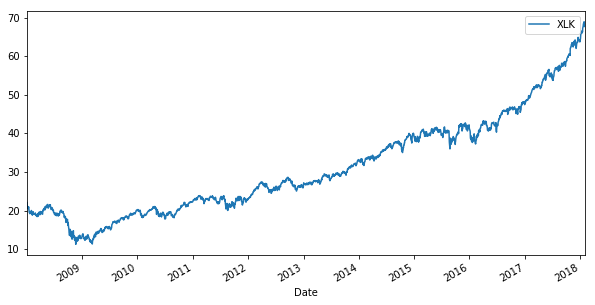

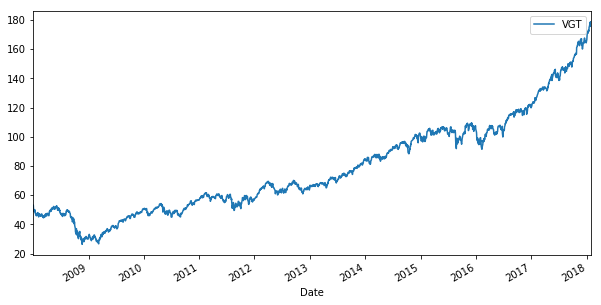

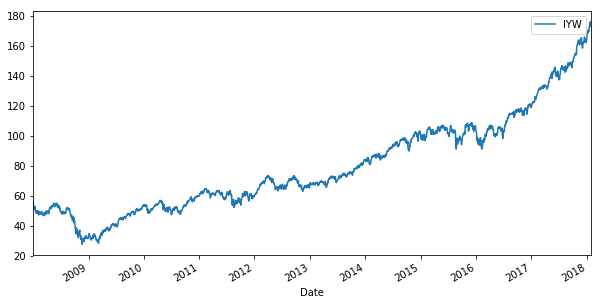

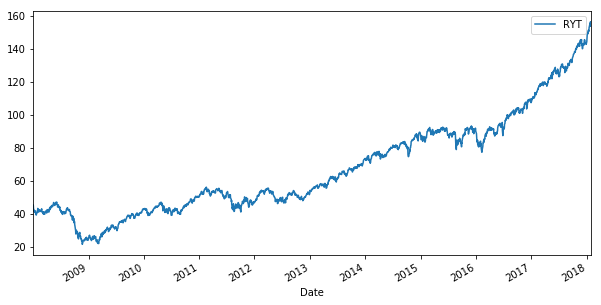

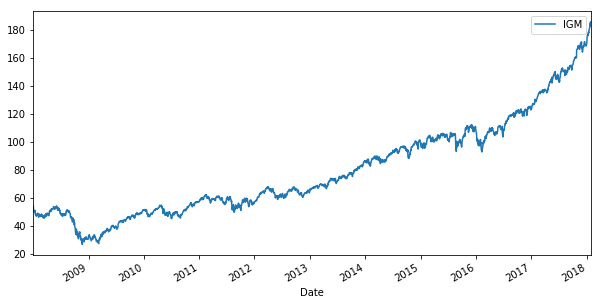

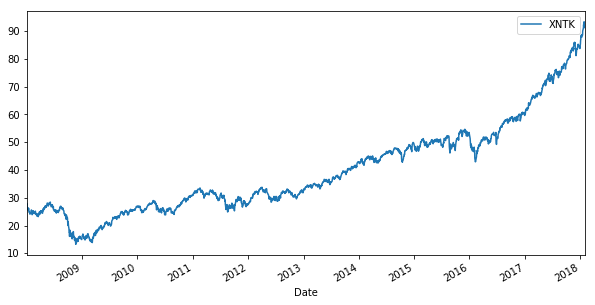

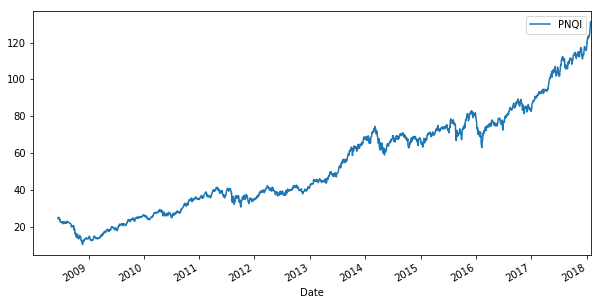

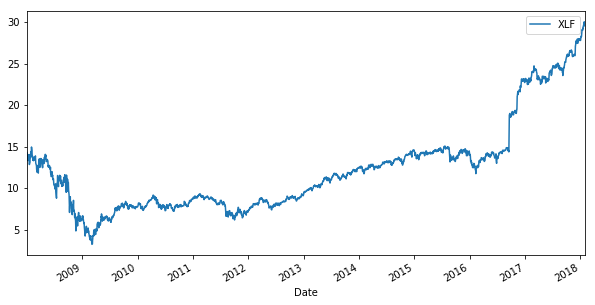

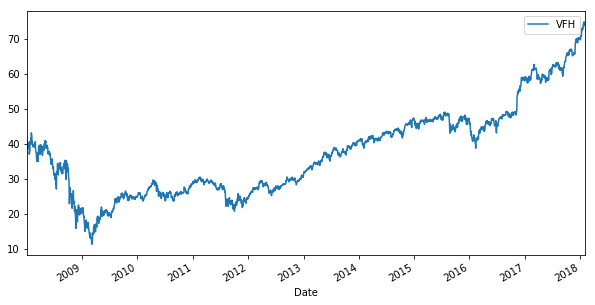

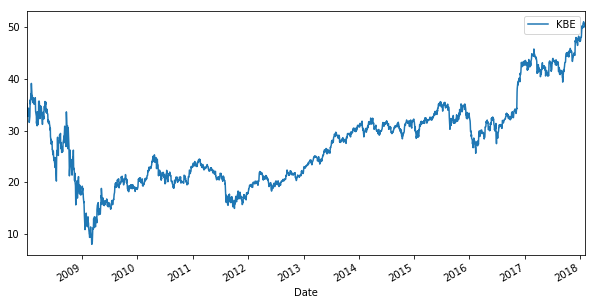

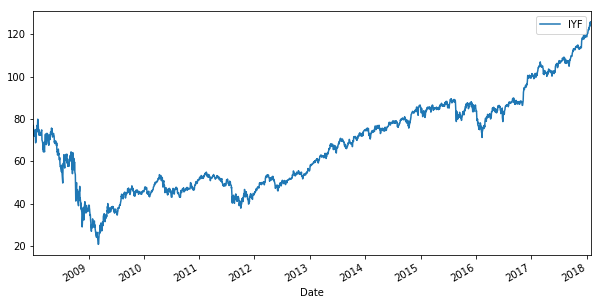

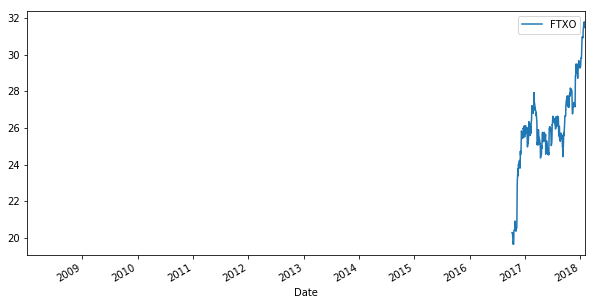

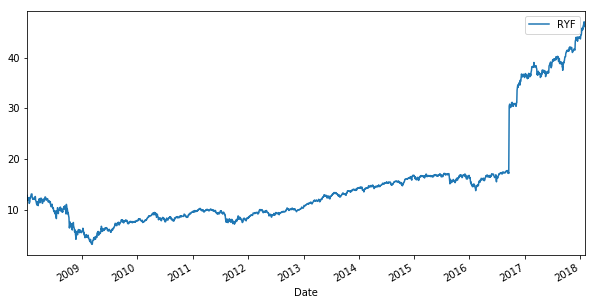

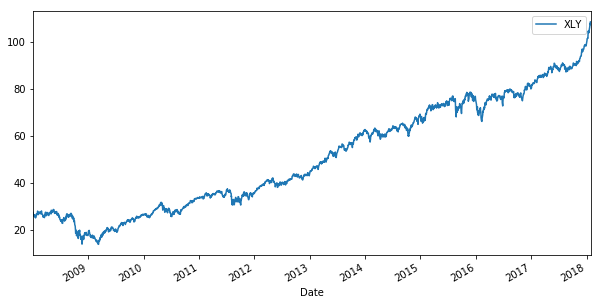

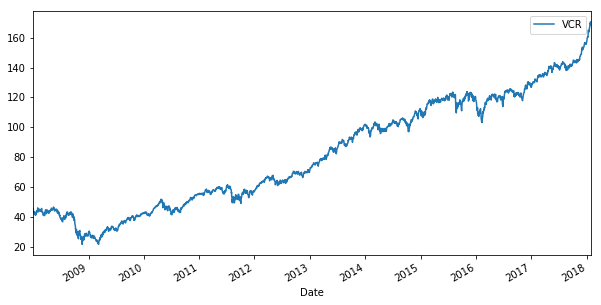

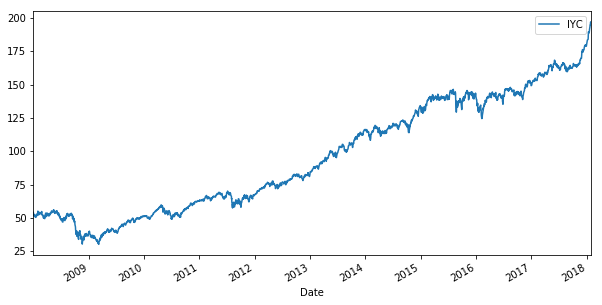

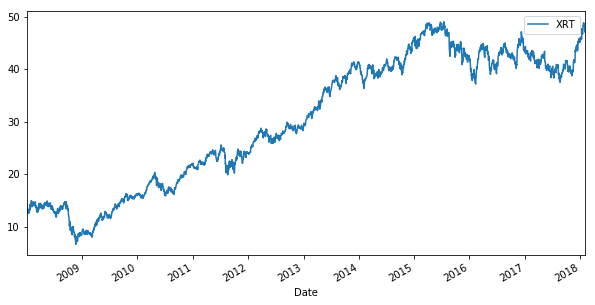

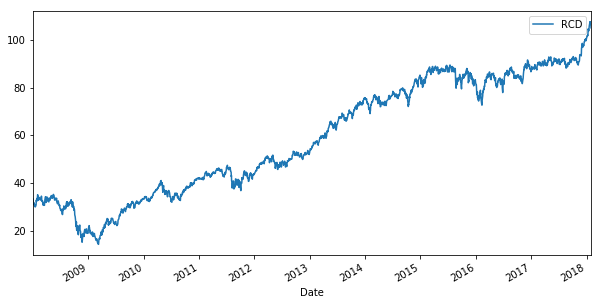

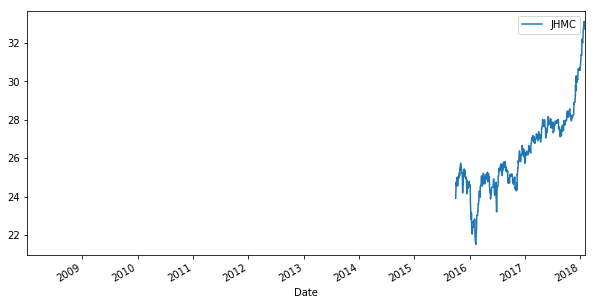

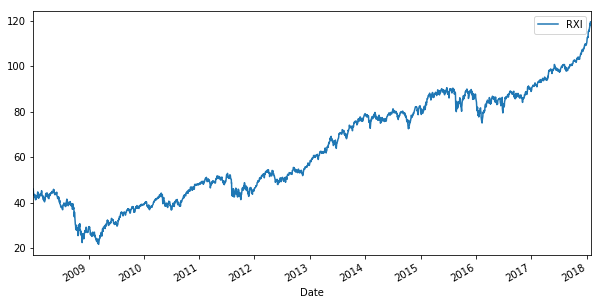

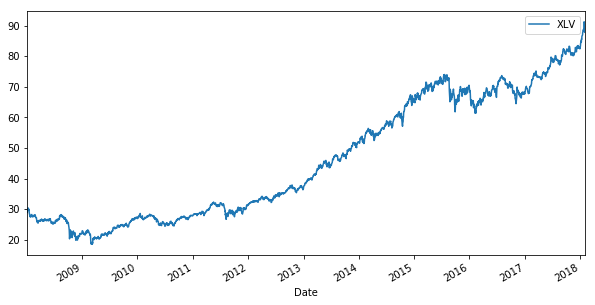

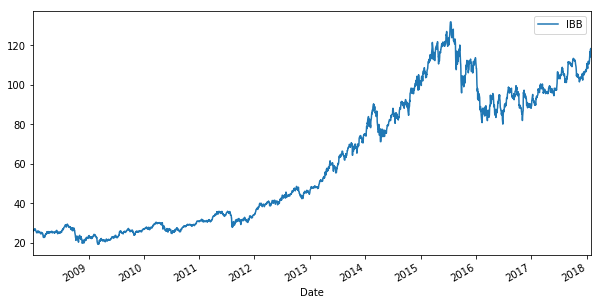

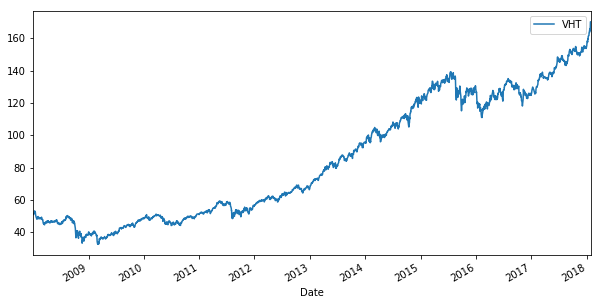

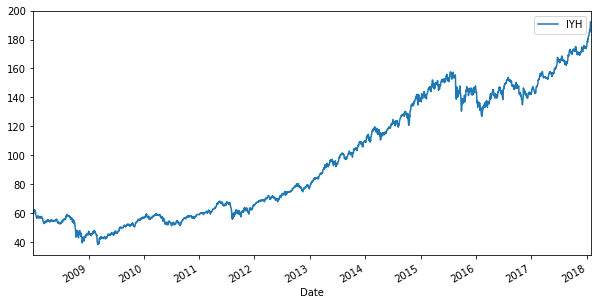

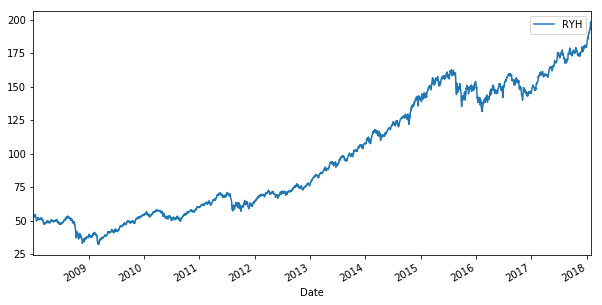

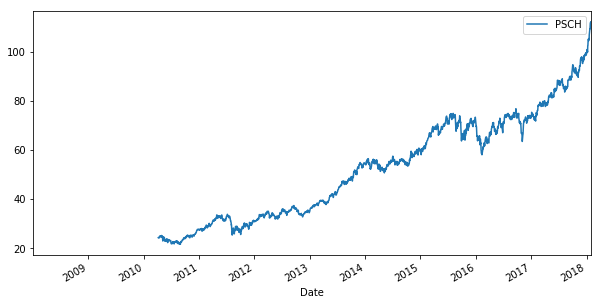

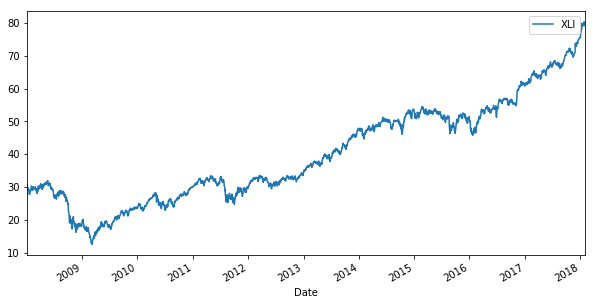

In [ ]:
for i in ETFs_GSPC.columns:

    ETFs_GSPC[[i]].plot(figsize=(10,5))

    plt.show()


In [ ]:
import pandas_datareader as pdr
pdr.get_data_yahoo('XLF').head()


In [ ]:
X_log.head()

In [ ]:
X_log = X.apply(np.log)

X_constant = sm.add_constant(X_log)

GSPC_log = np.log(GSPC)

sm_ols_results = sm.OLS(GSPC_log, X_constant).fit()

print(sm_ols_results.params)

print(sm_ols_results.summary())    

In [ ]:
ADF(sm_ols_results.resid.values.flatten())